# Imports

In [36]:
import numpy as np
from scipy.ndimage import convolve, maximum_filter
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') #avoid annoying imshow deprecated
import torch
import utils
import time
from PIL import Image
import os


# Simple data loading / sanity checking

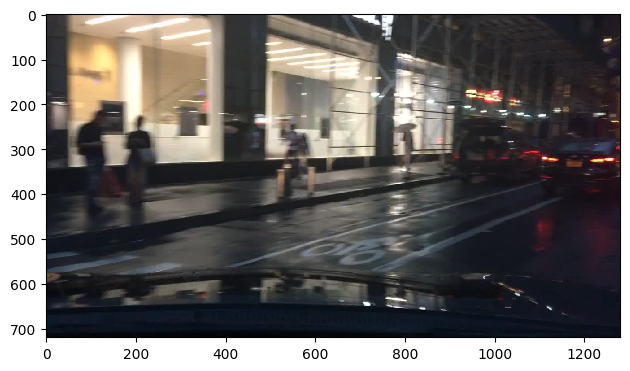

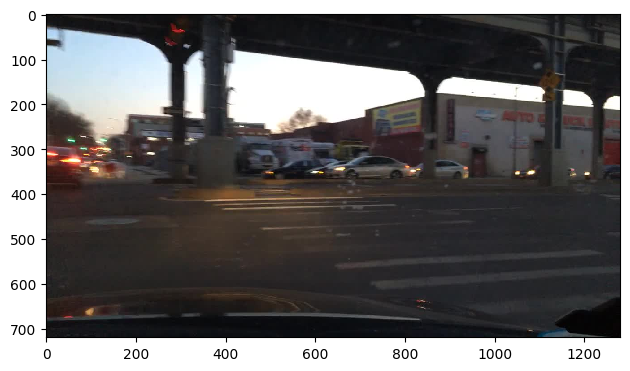

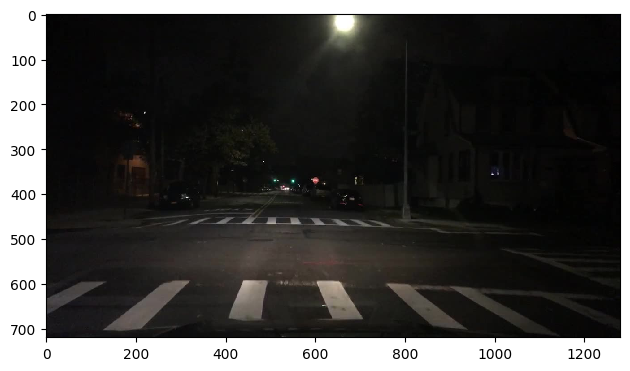

In [37]:
sample_images = utils.GET_SAMPLE_IMAGES()
utils.PLOT_SAMPLE_IMAGES(sample_images[:3])

In [38]:
sample_img = sample_images[0]

sample_img.shape #row x col x color

(720, 1280, 3)

In [39]:
sample_img

array([[[53, 51, 54],
        [53, 51, 54],
        [53, 51, 54],
        ...,
        [32, 27, 34],
        [32, 27, 34],
        [32, 27, 34]],

       [[53, 51, 54],
        [53, 51, 54],
        [53, 51, 54],
        ...,
        [32, 27, 34],
        [32, 27, 34],
        [32, 27, 34]],

       [[53, 51, 54],
        [53, 51, 54],
        [53, 51, 54],
        ...,
        [32, 27, 34],
        [32, 27, 34],
        [32, 27, 34]],

       ...,

       [[ 8,  7, 13],
        [ 8,  7, 13],
        [ 8,  7, 13],
        ...,
        [11, 15, 27],
        [11, 15, 27],
        [11, 15, 27]],

       [[ 7,  6, 12],
        [ 7,  6, 12],
        [ 7,  6, 12],
        ...,
        [11, 15, 27],
        [11, 15, 27],
        [11, 15, 27]],

       [[ 7,  6, 12],
        [ 7,  6, 12],
        [ 7,  6, 12],
        ...,
        [11, 15, 27],
        [11, 15, 27],
        [11, 15, 27]]], dtype=uint8)

In [40]:
len(sample_img[0,:,0]) #one col, should be 1280

1280

In [41]:
sample_img[0,0,:] #one rbg point

array([53, 51, 54], dtype=uint8)

# K-means clustering

In [62]:
# NAIVE / UNVECTORIZED K-MEANS
def kmeans_naive(image, k=3, max_iter=20, verbose=False):
    """
    Naive / Unvectorized K-Means (matches partner's naive KNN):
    - Python loop over pixels (N)
    - NumPy vector ops inside loop (1 vs K)
    """

    H, W, _ = image.shape
    x = image.reshape(-1, 3).astype(np.float64)
    N = x.shape[0]

    # init centroids (choose k random pixels)
    idx = np.random.choice(N, k, replace=False)
    centroids = x[idx].copy()

    for it in range(max_iter):
        if verbose:
            print(f"Iter {it+1}/{max_iter}")

        labels = np.zeros(N, dtype=np.int32)

        # ---- Assignment (loop over pixels) ----
        for i in range(N):
            diff = x[i] - centroids      # shape (K,3)
            dists = np.sqrt(np.sum(diff * diff, axis=1))  # vectorized over K
            labels[i] = np.argmin(dists)

        # ---- Update ----
        new_centroids = np.zeros_like(centroids)
        for c in range(k):
            pts = x[labels == c]
            if len(pts) > 0:
                new_centroids[c] = pts.mean(axis=0)
            else:
                # reinitialize empty centroid
                j = np.random.randint(0, N)
                new_centroids[c] = x[j]

        # ---- Convergence ----
        shift = np.linalg.norm(new_centroids - centroids)
        if verbose:
            print(f"Shift = {shift:.6f}")
        if shift < 1e-4:
            break

        centroids = new_centroids

    segmented = centroids[labels].reshape(H, W, 3).astype(np.uint8)
    return segmented, labels.reshape(H, W), centroids

In [63]:
# NUMPY VECTORIZED K-MEANS
def kmeans_numpy(image, k=3, max_iter=20, verbose=False):
    H, W, _ = image.shape
    x = image.reshape(-1, 3).astype(np.float64)
    N = x.shape[0]

    idx = np.random.choice(N, k, replace=False)
    centroids = x[idx].copy()

    for it in range(max_iter):
        if verbose:
            print(f"Iter {it+1}/{max_iter}")

        # ---- Vectorized assignment ----
        diff = x[:, None, :] - centroids[None, :, :]   # (N,K,3)
        dists = np.sqrt(np.sum(diff**2, axis=2))       # (N,K)
        labels = np.argmin(dists, axis=1)

        # ---- Update ----
        new_centroids = np.zeros_like(centroids)
        for c in range(k):
            pts = x[labels == c]
            if len(pts) > 0:
                new_centroids[c] = pts.mean(axis=0)
            else:
                j = np.random.randint(0, N)
                new_centroids[c] = x[j]

        # ---- Convergence ----
        shift = np.linalg.norm(new_centroids - centroids)
        if verbose:
            print(f"Shift = {shift:.6f}")
        if shift < 1e-4:
            break

        centroids = new_centroids

    segmented = centroids[labels].reshape(H, W, 3).astype(np.uint8)
    return segmented, labels.reshape(H, W), centroids

In [64]:
# GPU K-MEANS (PyTorch)
def kmeans_gpu(image, k=3, max_iter=20, verbose=False, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    device = torch.device(device)

    H, W, _ = image.shape
    x = torch.tensor(image.reshape(-1, 3), dtype=torch.float32, device=device)
    N = x.shape[0]

    # init centroids
    idx = torch.randint(0, N, (k,), device=device)
    centroids = x[idx].clone()

    for it in range(max_iter):
        if verbose:
            print(f"Iter {it+1}/{max_iter}")

        # ---- GPU-accelerated assignment ----
        dists = torch.cdist(x, centroids)     # (N,K)
        labels = torch.argmin(dists, dim=1)

        # ---- Update ----
        new_centroids = []
        for c in range(k):
            pts = x[labels == c]
            if pts.shape[0] > 0:
                new_centroids.append(pts.mean(dim=0))
            else:
                j = torch.randint(0, N, (1,), device=device)
                new_centroids.append(x[j][0])
        new_centroids = torch.stack(new_centroids)

        # ---- Convergence ----
        shift = torch.norm(new_centroids - centroids)
        if verbose:
            print(f"Shift = {shift.item():.6f}")
        if shift.item() < 1e-4:
            break

        centroids = new_centroids

    segmented = centroids[labels].reshape(H, W, 3).cpu().numpy().astype(np.uint8)
    return segmented, labels.cpu().reshape(H, W), centroids.cpu().numpy()

In [45]:
# benchmark
def benchmark(fn, image, name):
    start = time.time()
    seg, labels, cents = fn(image)
    end = time.time()

    elapsed = end - start
    fps = 1.0 / elapsed

    return {
        "method": name,
        "time": elapsed,
        "fps": fps
    }


# ----------------------------------------
# RUN ALL 3 BENCHMARKS
# ----------------------------------------
def run_all_benchmarks(image):
    results = []

    results.append(benchmark(lambda img: kmeans_naive(img), image, "Naive"))
    results.append(benchmark(lambda img: kmeans_numpy(img), image, "NumPy"))
    results.append(benchmark(lambda img: kmeans_gpu(img), image, "GPU"))

    return results



def print_benchmark_table(results):
    print("\n=== K-Means Benchmark Results ===\n")
    print(f"{'Method':<10} {'Time (s)':<10} {'FPS':<10}")
    print("-" * 32)

    for r in results:
        print(f"{r['method']:<10} {r['time']:<10.4f} {r['fps']:<10.4f}")

#results = run_all_benchmarks(sample_img)
#print_benchmark_table(results)

In [74]:
import os
import numpy as np
from PIL import Image
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt

# -------------------------------------------------------------
#  Convert palette/PNG mask to region-based GT from RGB colors
# -------------------------------------------------------------
def gt_to_region_ids(mask_path):
    arr_rgb = np.array(Image.open(mask_path).convert("RGB"))
    h, w, _ = arr_rgb.shape

    flat = arr_rgb.reshape(-1, 3)
    uniq, inv = np.unique(flat, axis=0, return_inverse=True)

    gt_region_ids = inv.reshape(h, w)
    return gt_region_ids


# -------------------------------------------------------------
#  ARI on region-based GT
# -------------------------------------------------------------
def compute_ari_region(pred_labels, gt_region_ids):
    return adjusted_rand_score(
        gt_region_ids.flatten(),
        pred_labels.flatten()
    )


# -------------------------------------------------------------
#  Loader using your repo structure
# -------------------------------------------------------------
def load_bdd100k_pair(base_dir, split, filename):
    img_path = os.path.join(base_dir, "10k", split, filename + ".jpg")
    mask_path = os.path.join(base_dir, "bdd100k_seg_maps", "labels", split, filename + "_train_id.png")

    img = np.array(Image.open(img_path).convert("RGB"))
    return img, mask_path   # return mask_path instead of mask array


# -------------------------------------------------------------
#  Run all K-means + ARI (using region-ID GT)
# -------------------------------------------------------------
def run_all_kmeans_with_ari(image, gt_region_ids):
    results = []

    # ----- Naive -----
    seg, labels, _ = kmeans_naive(image)
    ari = compute_ari_region(labels, gt_region_ids)
    naive_bench = benchmark(kmeans_naive, image, "Naive")
    naive_bench["ari"] = ari
    results.append(naive_bench)

    # ----- NumPy -----
    seg, labels, _ = kmeans_numpy(image)
    ari = compute_ari_region(labels, gt_region_ids)
    numpy_bench = benchmark(kmeans_numpy, image, "NumPy")
    numpy_bench["ari"] = ari
    results.append(numpy_bench)

    # ----- GPU -----
    seg, labels, _ = kmeans_gpu(image)

    # Plot GT vs Pred
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title("GT Region IDs (RGB-based)")
    plt.imshow(gt_region_ids, cmap='tab20')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Labels")
    plt.imshow(labels, cmap='tab20')
    plt.axis('off')
    plt.show()

    ari = compute_ari_region(labels, gt_region_ids)
    gpu_bench = benchmark(kmeans_gpu, image, "GPU")
    gpu_bench["ari"] = ari
    results.append(gpu_bench)

    return results


# -------------------------------------------------------------
#  Print performance + ARI table
# -------------------------------------------------------------
def print_ari_table(results):
    print("\n=== K-Means Benchmark + ARI (RGB Region-ID GT) ===\n")
    print(f"{'Method':<10} {'Time (s)':<10} {'FPS':<10} {'ARI':<10}")
    print("-" * 48)
    for r in results:
        print(f"{r['method']:<10} {r['time']:<10.4f} {r['fps']:<10.4f} {r['ari']:<10.4f}")

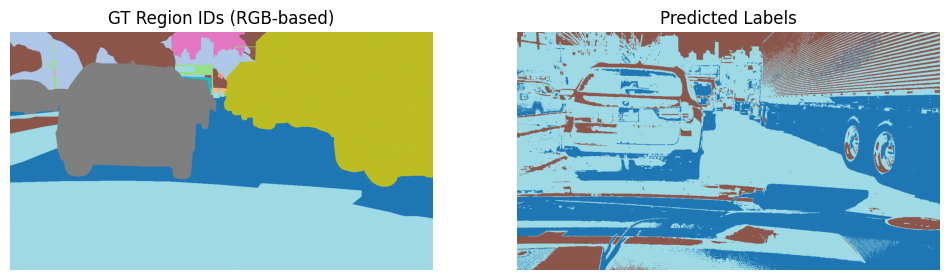


=== K-Means Benchmark + ARI (RGB Region-ID GT) ===

Method     Time (s)   FPS        ARI       
------------------------------------------------
Naive      22.6192    0.0442     0.0370    
NumPy      0.7196     1.3896     0.0370    
GPU        0.2244     4.4565     0.0370    


In [75]:
# Load image + mask path
img, mask_path = load_bdd100k_pair(base_dir=".", split="val", filename="7d2f7975-e0c1c5a7")

# Convert GT to region IDs (correct handling of palette)
gt_region_ids = gt_to_region_ids(mask_path)

# Run benchmarks and ARI
results = run_all_kmeans_with_ari(img, gt_region_ids)

# Print results
print_ari_table(results)